# package install

In [ ]:
# %pip install langchain.chat_model
# %pip install langchain_community
# %pip install langchain
# %pip install -U langchain-openai
# %pip install openai
# %pip install pypdf
# %pip install unstructured
# %pip install python-magic-bin
# %pip install "unstructured[docx]"
# %pip install -U langchain-openai langchain-unstructured
# %pip install -U langchain-unstructured
# %pip install chromadb

# %pip check
# %pip list | findstr "^langchain"

# Load
    # Data Loaders and Spliters

##### 문서 load

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import UnstructuredFileLoader # 다양한 확장자의 파일을 열 수 있다.

# loader0 = TextLoader("./files/chapter_one.txt")
# loader0.load()

# loader1 = PyPDFLoader("./files/chapter_one.pdf")
# loader1.load()

# 강의에서는 UnstructuredFileLoader 를 사용할 것이다.
loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load()

##### 문서 분할
- 문서의 덩어리가 너무 크기 때문에 나눠야 한다.
    1. 답변 생성에 필요한 context를 찾기 쉽다.
    2. LLM 에게 질문과 연관된 자료를 줄 때 필요한 '파일의 부분들'만 전달할 수 있다.
    3. 그러면 Prompt 의 길이도 짧아진다. by 딱 필요한 부분만 주기 때문에

##### 이를 위해
- 문서의 모든 문자를 조각낸다.(모든 문자를 작은 조각들로 만든다.)

In [ ]:
# RecursiveCharacterTextSplitter
    # 일반적인 Text Splitter
    # 문장 혹은 문단의 끝부분마다 끊어주는(분할) 역할 --> 뜬금없이 문장의 중간을 끊지 않는다.
    # 쉽게 말해 -> 문장과 문단 구조를 유지하면서 문서를 쪼개는 것이다.
# CharacterTextSplitter
    # 지정한 문자열을 기준으로 끊을 수 있다. --> separator 속성
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

# chunk 가 작을수록 더 좋다.
splitter = RecursiveCharacterTextSplitter(
    chunk_size    = 200,# 얼마나 큰 덩어리로 쪼갤 것이냐
    chunk_overlap = 50  # 분할된 조각들의 내용을 얼마나 겹치게 할 것이냐
)

splitter2 = CharacterTextSplitter(
    separator     ="\n",# 지정한 문자열을 찾은 다음 거기서부터 끊는다.
    chunk_size    = 600,# 얼마나 큰 덩어리로 쪼갤 것이냐
    chunk_overlap = 100 # 분할된 조각들의 내용을 얼마나 겹치게 할 것이냐
)

loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load_and_split(text_splitter=splitter2)

# Transform
    # Tiktoken

- 기본적으로 모든 Splitter 들은 텍스트의 length 를 계산해 한 덩어리(chunk)의 크기를 알아낸다.
- 이 과정에서 사용하는 것이 python 내장 함수 len function 이다.

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

splitter = CharacterTextSplitter(
    separator       ="\n",
    chunk_size      = 600,
    chunk_overlap   = 100,
    length_function = len
    # len 함수 외에 내가 직접 만든 커스텀 함수도 지정할 수 있다.
    # RecursiveCharacterTextSplitter 에서도 지정할 수 있다.
)

loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load_and_split(text_splitter=splitter)

- LLM 들은 Token 을 인간과 같은 방식으로 계산하지 않는다.
- 경우에 따라 문자 2개, 3개가 하나의 token 으로 취급 될 때가 있다.
- 즉, token과 letter(character, 문자)는 같은 의미가 아니다.

https://platform.openai.com/tokenizer
- LLM 관점에서 token 개수를 알 수 있다. -> token과 characters의 차이를 알 수 있다.
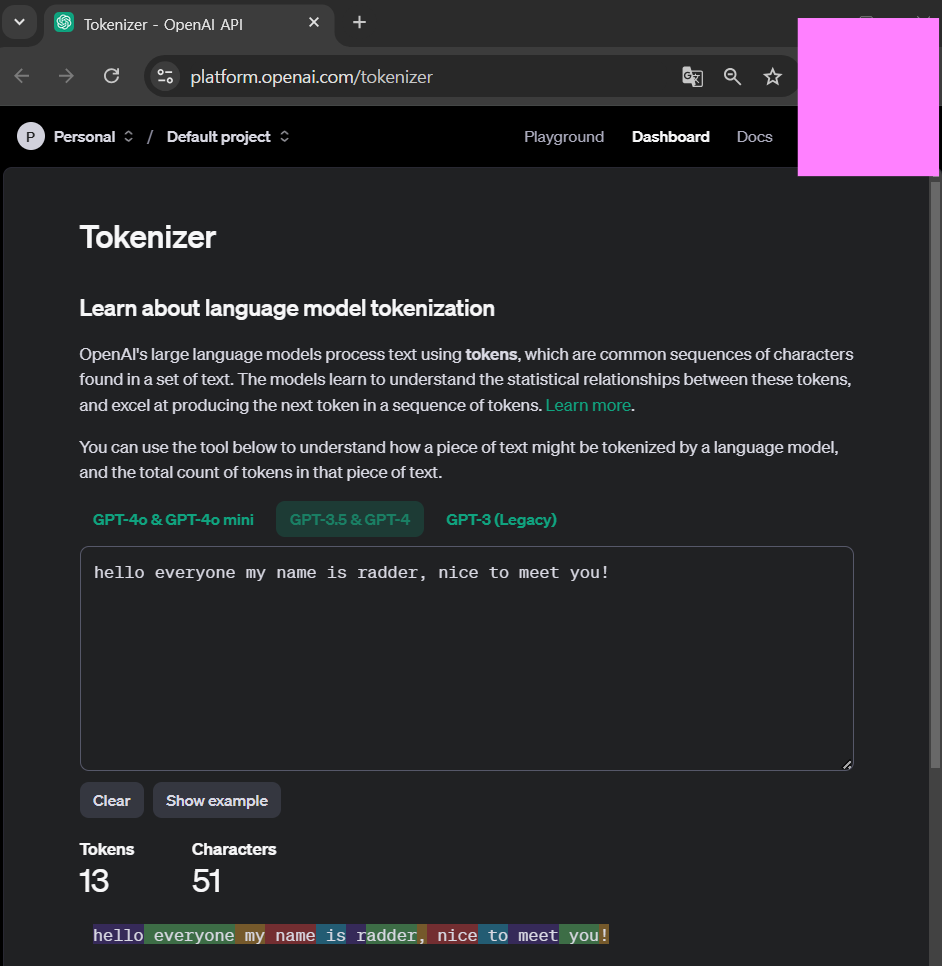
- Tokens는 13, characters는 51 이다.
- 몇 개만 예를들어 보면 LLM은
    - hello, everyone 등은 하나의 token 으로 취급한다.(공백 포함)
        - 인간 입장에서는 각각 5글자(hello), 8글자(everyone)
    - 그러나 radder는 2개의 token 으로 취급한다.(공백 포함)
        - 인간 입장에서는 6글자(radder)

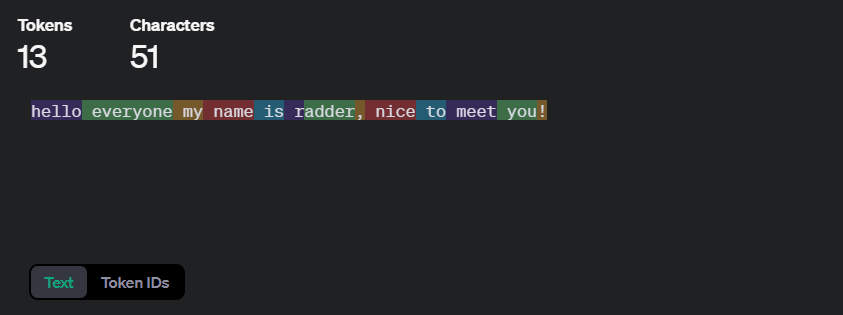
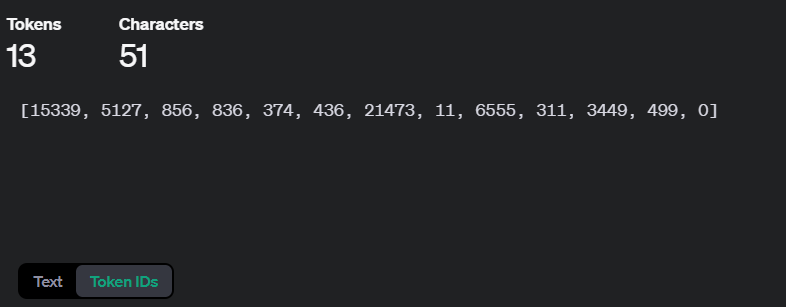
- Token IDs 가 LLM 이 실제로 보고있는 것이다.
- 내가 입력한 text가 LLM 에게는 이러한 숫자들의 묶음으로 보이는 것이다.

In [ ]:
# splitter에 위에서 설명한 token 개념을 사용할 수 있는 tokenizer(토큰화) 함수를 사용해보자
# by Python 기본 함수인 len 함수를 사용하기 싫다.

from langchain.text_splitter import CharacterTextSplitter

# from_tiktoken_encoder를 추가했다.(tiktoken은 OpenAI에서 만들었다.)
splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator     ="\n",
    chunk_size    = 600,
    chunk_overlap = 100
)

loader = UnstructuredFileLoader("./files/chapter_one.docx")
loader.load_and_split(text_splitter=splitter)

    # from_tiktoken_encoder
- 텍스트 데이터를 token 단위로 변환하기 위해 사용
- 텍스트를 embedding 하기 전에 미리 토큰화하여 길이를 확인 or 특정 모델의 token 개수 제한을 맞추기 위해 사용한다.

    # 쉽게 말해
- 원본 텍스트를 LLM 모델이 처리하기 쉬운 형태로 변환하는 과정이므로 tramsform 과정에 해당한다.
- 텍스트를 token으로 변환한 후 해당 token 들을 기반으로 embedding 을 수행할 수 있다.

# Embed
    # Vectors

- Embedding
    - 사람이 읽는 텍스트를 컴퓨터가 이해할 수 있는 숫자들로 변환하는 작업
    - 숫자 = vector
- 즉, vector들을 만드는 작업 = Token을 숫자 vector로 변환하는 과정
- load_and_split 한 문서들을 전부 숫자로 변환하는 것이다.
- 숫자로 치환함에 따라 vector에 대한 search(검색) 작업을 할 수 있다.

- RAG
    - vector 들을 사용해 비슷한 문서(비슷한 vector)들을 **검색**한다.
        - 검색 in Vector DataBase
        - 비슷한 = 서로 가까운 vector
    - **Vector DataBase에서 연관성이 높은 문서를 찾아 LLM에게 전달**
    - LLM은 이것을 기반으로 답변을 생성한다.

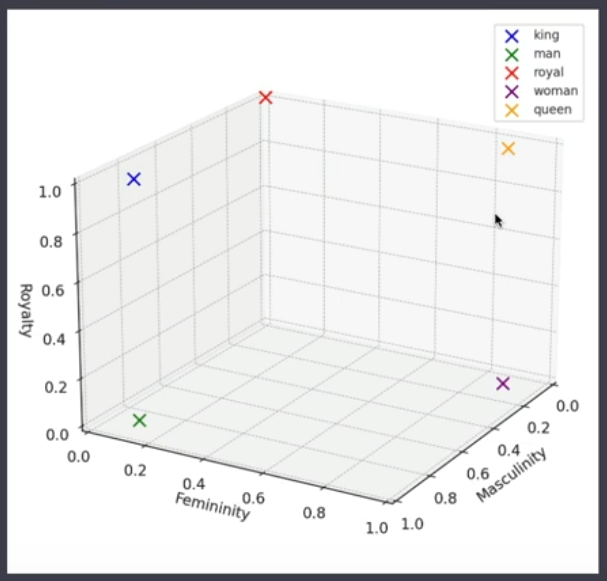

https://turbomaze.github.io/word2vecjson/
- 입력한 단어와 비슷한 vector를 가진 단어들을 보여주는 사이트

    # vertor store

- 일종의 DataBase = vector가 저장되는 곳
- vector 공간에서 검색할 수 있게 해준다.

In [ ]:
# load_and_split 한 문서를 embed 해보자

from langchain.document_loaders import UnstructuredFileLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
# [as-is] by deprecated
# from langchain.embeddings import OpenAIEmbeddings
# [to-be]
from langchain_openai import OpenAIEmbeddings

# load
loader = UnstructuredFileLoader("./files/chapter_one.docx")

# split
splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator="\n",
    chunk_size=600,
    chunk_overlap=100
)

# load_and_split
docs = loader.load_and_split(text_splitter=splitter)

# embedding 모델
embedding = OpenAIEmbeddings() # default model인 text-embedding-ada-002 사용

# embed & embed 된 문서를 Chroma에 저장(Pinecone도 동일한 역할)
# 저장하지 않으면 매번 코드가 실행될 때 마다 문서가 계속해서 embed 되는데 이는 성능과 비용 측면에서 모두 좋지않다.
vectorStore = Chroma.from_documents(
    # Chroma.from_documents() --> Chroma 초기화(Create a Chroma vectorstore)
    documents=docs,
    embedding=embedding
)

In [ ]:
# vector store에서 유사도 검색을 해보자 = 벡터 공간에 대한 검색을 하는 것이다.
# 여기서 나온 결과를 LLM에게 넘겨주고, LLM은 이를 기반으로 답변을 생성한다.
result = vectorStore.similarity_search("where does winston live", k=6) # k의 기본값 = 4
result

    # embedding cache 적용

##### 작업 순서
0. embedding 작업을 하려고 한다.
1. 이때 cache에 embedding이 이미 존재하는지 확인
    - 없다면 Chroma.from_documents 를 호출할 때 문서(docs)와 함께 OpenAIEmbeddings() 사용, 그 다음 결과가 cache 된다.
    - 있다면 이미 cache 되어있는 embedding을 가져온다.
2. 즉, 최초 한 번은 무조건 OpenAIEmbeddings() 를 사용할 수 밖에 없다.

In [ ]:
# 한 번 embed 하면 문서의 내용이 바뀌지 않는 한 embedding 도 변하지 않는다.
# 그렇기에 Langchain은 embedding 된 것들을 caching 하는 기능을 제공한다.
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# 캐시 경로 설정(해당 경로의 폴더에 embedding 이 저장된다.)
cache_dir = LocalFileStore("./cache/")

# cached embedding 생성
    # underlying_embeddings     --> embed에 사용할 embedding model
    # document_embedding_cache  --> embedding을 저장할 장소(cache 데이터 저장 장소)
cached_embedding = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings    = embedding,
    document_embedding_cache = cache_dir
)

# 앞으로 Chroma.from_documents 를 호출하면
# embedding = OpenAIEmbeddings() 대신 미리 cache 된 cached_embedding 이 전달된다.
# cache 된 것을 이용하는 것이기에 당연히 실행 시간도 줄어든다.
vectorStore = Chroma.from_documents(
    documents=docs,
    # embedding=embedding       # [cache 적용 전]
    embedding=cached_embedding  # [cache 적용 후]
)

# Langsmith

- Langsmith를 통해 내가 만든 chain이 어떤 작업을 하고있는지 시각적으로 볼 수 있다.
- .env 파일에 아래와 같이 환경변수들을 등록하면 된다.

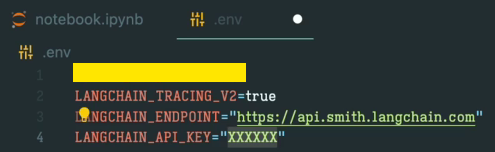

# RetrievalQA

- document chain 에 대해 알아보는 시간
- load_and_split 한 document 를 이용해 LLM 에게 질문을 해볼 것이다.
- 단, chain 을 새로 만들 것이 아니라 **off-the-shelf chain** 을 사용할 것이다.
    - 해당 꼭지에서 off-the-shelf chain = RetrievalQA

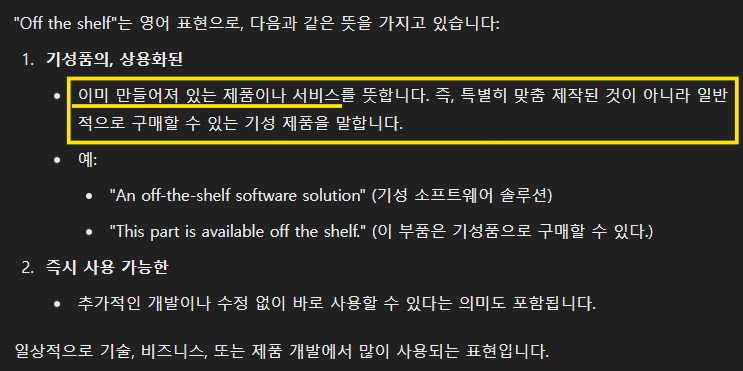

- document chain 에는 다양한 type 이 있다.
1. Stuff : 내가 찾은 document들로 prompt를 stuff(채우기) 하는데 사용
    1. 사용자가 질문을 한다.
    2. 해당 질문을 바탕으로 document를 search
    3. 찾은 document를 prompt에 입력해서 LLM에게 전달
    4. LLM은 (**사용자 질문 & document**)를 바탕으로 답변 생성
2. Refine
3. Map reduce
4. Map re-rank

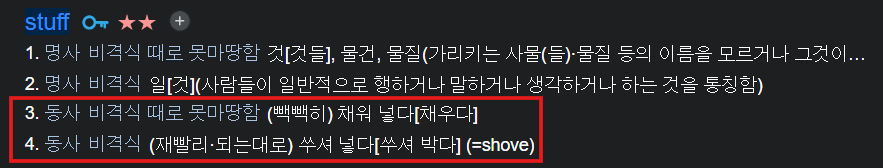

In [ ]:
# off-the-shelf chain(이미 만들어져있는 chain = RetrievalQA)을 사용해보자
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

llm = ChatOpenAI()

vectorStore = Chroma.from_documents(
    documents=docs,
    # embedding=embedding       # [cache 적용 전]
    embedding=cached_embedding  # [cache 적용 후]
)

chain = RetrievalQA.from_chain_type(
    llm         = llm,
    chain_type  = "stuff", # chain_type의 default = stuff
    retriever   = vectorStore.as_retriever()
)

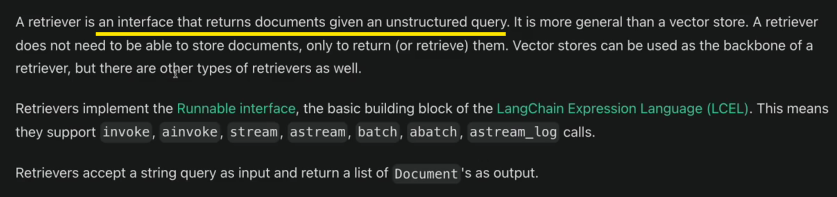

    # retriever = vectorStore.as_retriever()
- retriever : class의 interface
- vector store, Cloud 등에서 document를 선별하여(Retrieve) 가져올 수 있다.
- 즉, retriever 를 이용하면 document 들을 database에서 검색할 수도 있고, cloud나 vector store 등에서 찾아올 수 있다.

    # 강사가 말을 너무 어렵게 해서 Claude 한테 물어봤다.
-  RetrievalQA chain은 문서를 검색하는 기능을 가진 **Retriever Interface**를 필요로 한다.
- 이때 **as_retriever()** method는 벡터 저장소를 **Retriever Interface에 맞게 변환**해주는 역할을 한다.
- vectorStore.as_retriever() => Retriever 인터페이스를 구현한 객체

- vectorStore(벡터 저장소)
    - 문서들을 embedding 백터 형태로 저장하는 DataBase
    - 현재 Chroma DB 사용 중

- 작동 방식(아래 코드 참고)
    1. 사용자 질문이 들어오면 해당 질문을 vector로 변환
    2. **retriever가** 해당 vector와 가장 유사한 문서들을 벡터 저장소에서 검색
    3. 기본적으로 코사인 유사도를 사용해 가장 관련성 높은 문서 4개를 반환한다.

- 아래와 같이 변환된 retriever 는 RetrievalQA chain에서 질문과 관련된 문서들을 효과적으로 검색하는데 사용된다.

In [ ]:
# 검색 파라미터 커스터마이즈 예시
retriever = vectorStore.as_retriever(
    search_type="similarity", # 유사도 검색 방식
    k=4,                      # 반환할 문서 개수
    search_kwargs={"k": 4}    # 검색 관련 추가 파라미터
)

    # 한 문장으로 정리해서
- vectorStore.as_retriever() : 저장된 문서들 중에서 사용자의 질문과 가장 관련 있는 문서들을 찾아오는 **검색기(retriever) 역할을 하는 객체 생성**한다.

# LCEL chain

- 이전 글에서 off-the-shelf chain(RetrievalQA)를 알아봤다.
- 이번 시간에는 LCEL 을 이용해 나만의 chain 을 만들어 볼 것이다.
    - LCEL = LangChain Expression Language